In [24]:
from math import log
import random
from matplotlib import pyplot
from numpy import linspace
from scipy.integrate import odeint
import copy
from .core import log, Mersenne

In [29]:

"""Stochastic Simulation Algorithm (SSA)"""



__all__ = ["SSA", "SSAModel"]


class SSA:
    """Container for the SSA"""

    def __init__(self, model, seed=1234):
        """Initialize container with model"""
        self.model = model
        self.random = Mersenne(seed=seed)

    def direct(self):
        """Indefinite generator of direct-method trajectories"""
        while True:
            while not self.model.exit():
                weights = [
                    (rxn, sto, pro(self.model))
                    for (rxn, sto, pro)
                    in self.model.events
                ]
                partition = sum(w[-1] for w in weights)
                sojourn = log(
                    1.0 / self.random.floating()
                ) / partition
                self.model["time"].append(
                    self.model["time"][-1] + sojourn
                )
                partition = partition * self.random.floating()
                while partition >= 0.0:
                    rxn, sto, pro = weights.pop()
                    partition -= pro
                for species, delta in sto.items():
                    self.model[species].append(
                        self.model[species][-1] + delta
                    )
                self.model.curate()
            yield self.model
            self.model.reset()
            
    def first_reaction(self):
        """Indefinite generator of 1st-reaction trajectories"""
        while True:
            while not self.model.exit():
                times = [
                    (
                        log(
                            1.0 / self.random.floating()
                        ) / pro(self.model),
                        sto
                    )
                    for (rxn, sto, pro) in self.model.events
                ]
                times.sort()
                self.model["time"].append(
                    self.model["time"][-1] + times[0][0]
                )
                for species, delta in times[0][1].items():
                    self.model[species].append(
                        self.model[species][-1] + delta
                    )
                self.model.curate()
            yield self.model
            self.model.reset()


class SSAModel(dict):
    """Container for SSA model"""

    def __init__(
        self,
        initial_conditions,
        propensities,
        stoichiometry,
        total_steps=None,
        max_duration=None,
        until_end=False
    ):
        """Initialize model"""
        super().__init__(**initial_conditions)
        for sto in stoichiometry.values():
            if "time" in sto:
                raise Exception("error, 'time' can't be in stoichiometry.")
        if (total_steps == None) and (max_duration == None) and (until_end == True):
            raise Exception("error, the simulation might run forever. please input upper boundary.")
        self.max_duration = max_duration
        self.total_steps = total_steps
        self.until_end = until_end
        self.events = list()
        self.excluded_events = list()
        for event, propensity in propensities.items():
            if propensity(self) == 0.0:
                self.excluded_events.append(
                    (event, stoichiometry[event], propensity)
                )
            else:
                self.events.append(
                    (event, stoichiometry[event], propensity)
                )
        self.events.sort()
        self.excluded_events.sort()

    def exit(self):
        """Return True to break out of trajectory"""
        if self.max_duration is not None:
            if self["time"][-1] >= self.max_duration:
                return True
        if self.total_steps is not None:
            if len(self["time"]) == self.total_steps: 
                return True
        if self.until_end is False:
            if len(self.events) == 0:
                return True
        return False

    def curate(self):
        """Validate and invalidate elementary events"""
        events = []
        while len(self.events) > 0:
            event = self.events.pop()
            if event[2](self) == 0:
                self.excluded_events.append(event)
            else:
                events.append(event)
        self.events = events
        excluded_events = []
        while len(self.excluded_events) > 0:
            event = self.excluded_events.pop()
            if event[2](self) > 0:
                self.events.append(event)
            else:
                excluded_events.append(event)
        self.excluded_events = excluded_events

    def reset(self):
        """Clear the trajectory"""
        for key in self:
            del self[key][1:]
        self.curate()

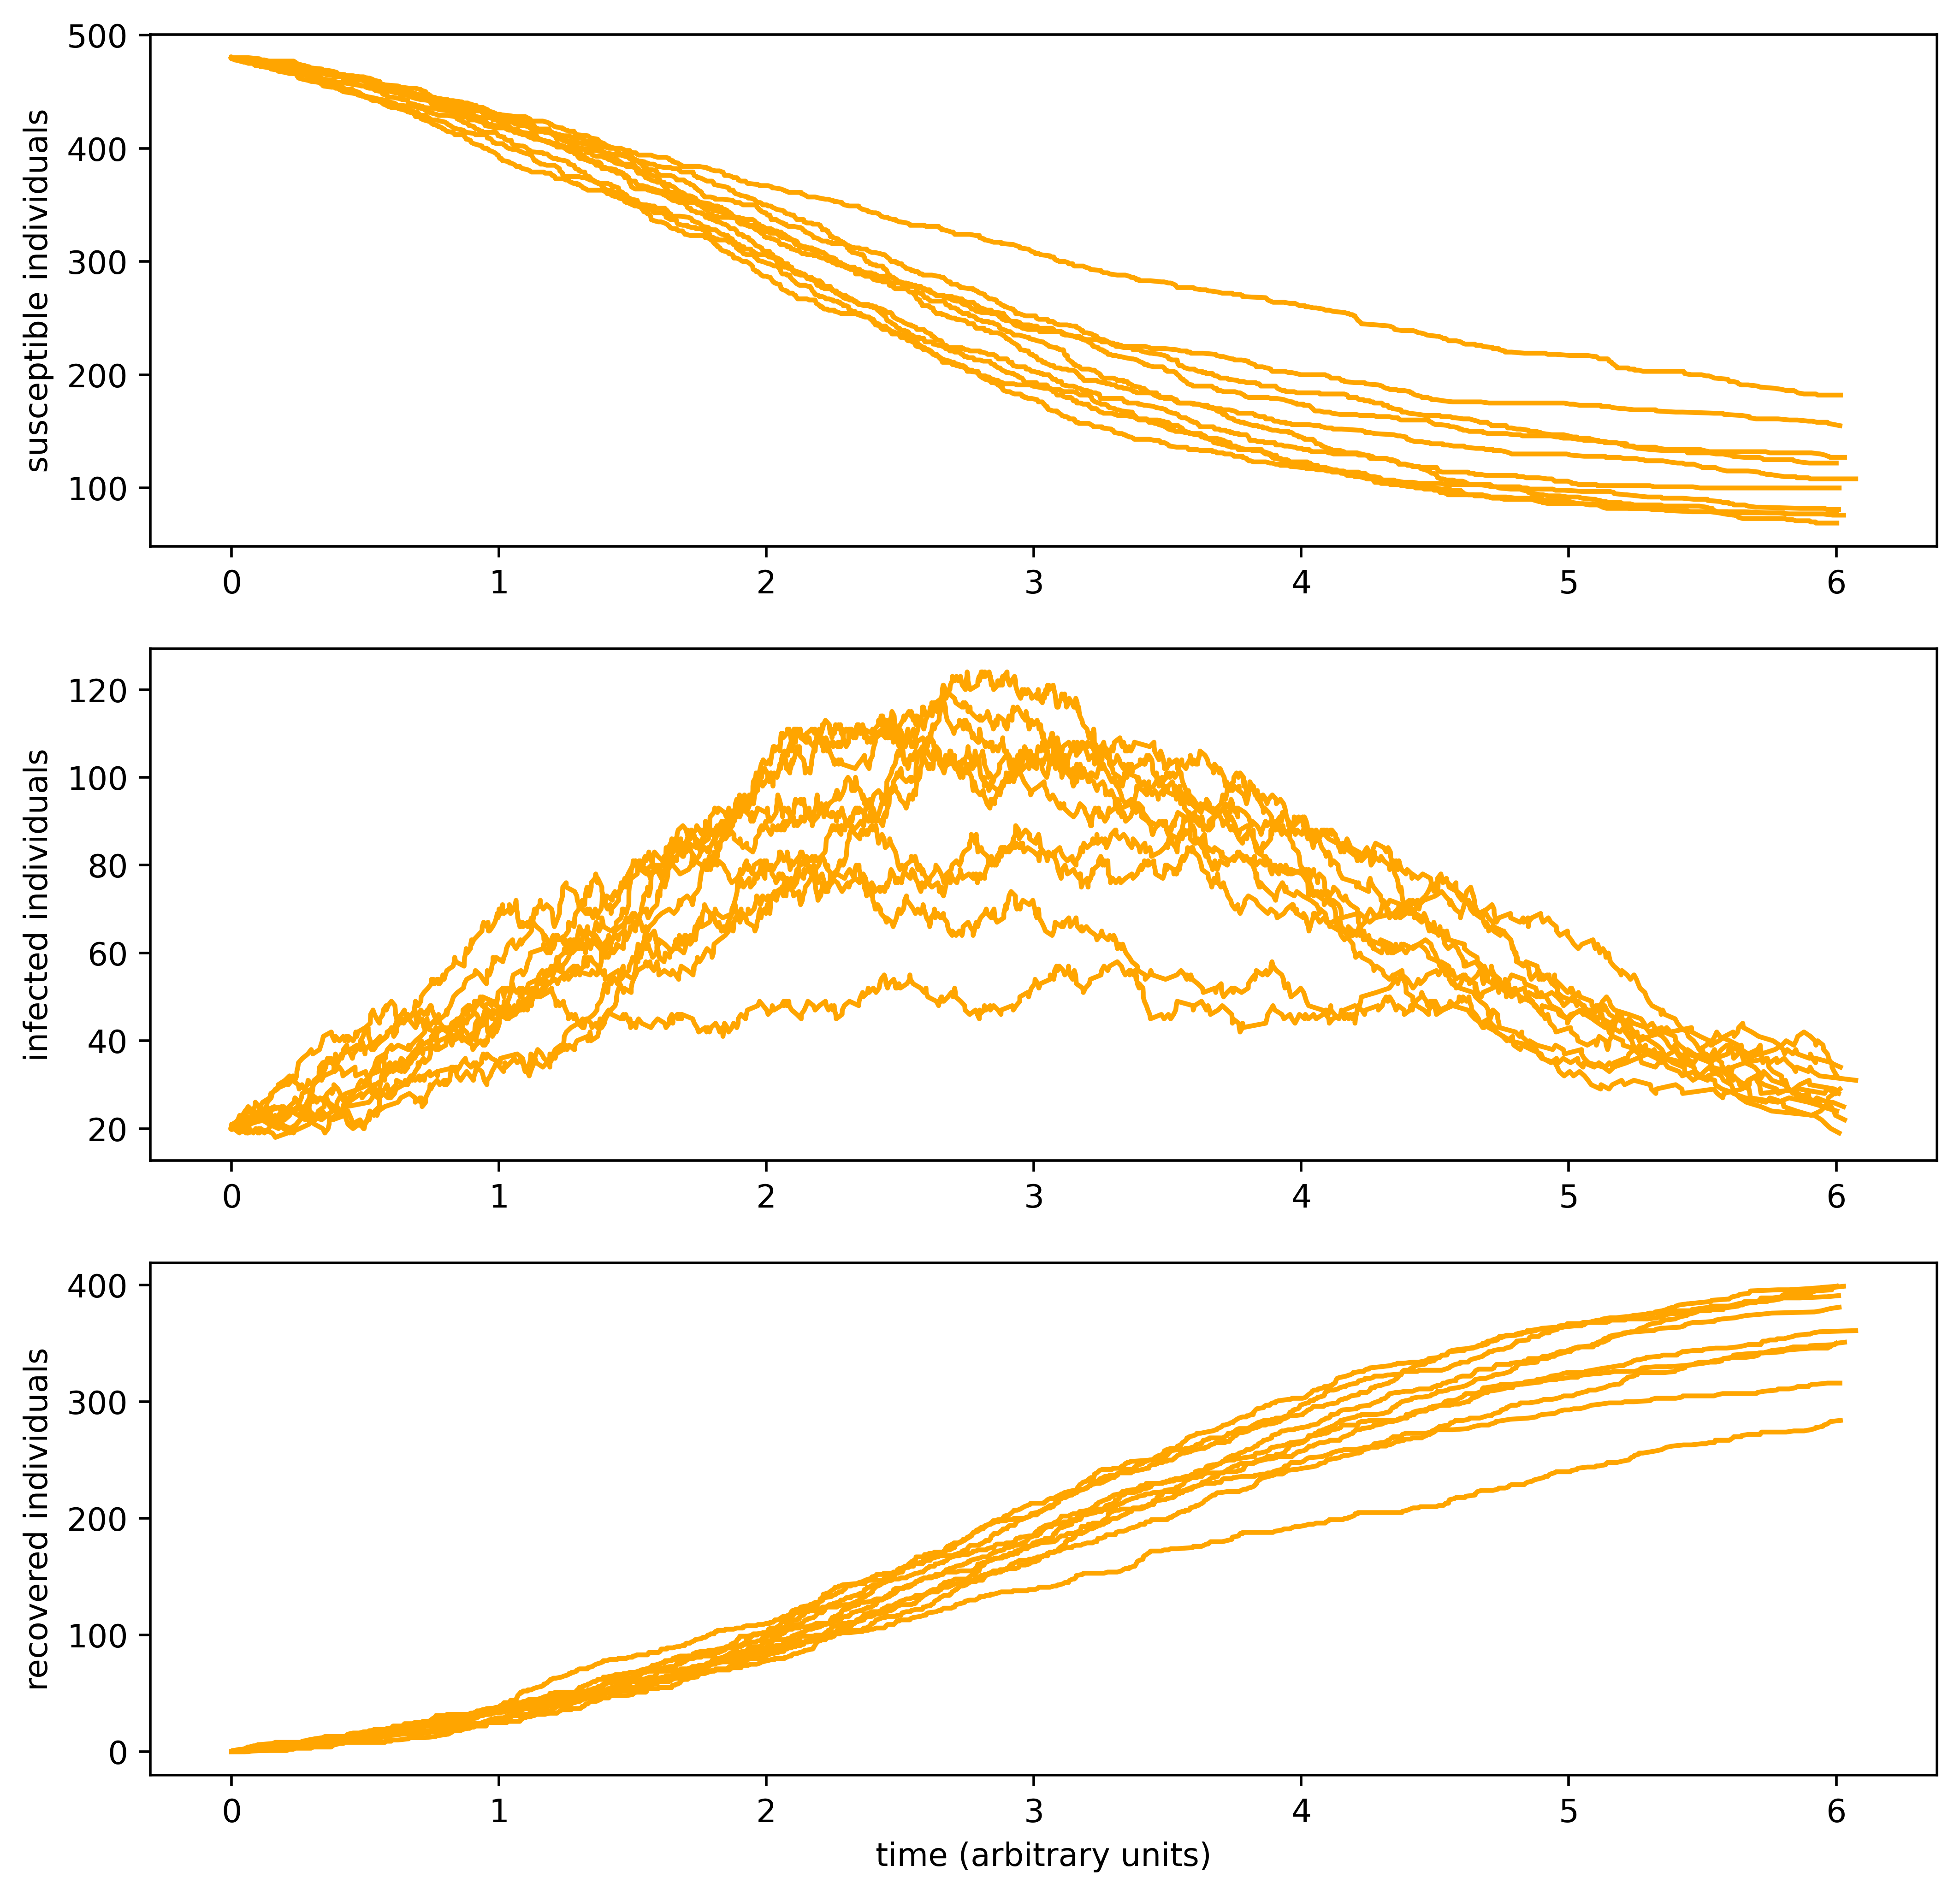

In [33]:
# this cell declares all the simulation parameters and objects

# set transition rates
al, be = 1.0, 1.0   # alpha, beta
nu, la = 10.0, 5.0  # nu, lambda
K, de = 100.0, 10.0 # K, delta


# set initial conditions
initial_conditions = {
    "C": [1],
    "B": [0],
    "A": [0],
    "mRNA": [0],
    "NULL": [0],
    "time": [0.0]
}


# set propensities
propensities = {
    0: lambda d: al * d["C"][-1],   # C -> B
    1: lambda d: be * d["B"][-1],   # C <- B
    2: lambda d: la * d["B"][-1],   # B -> A
    3: lambda d: nu * d["A"][-1],   # B <- A
    4: lambda d: K * d["A"][-1],    # mRNA + 1
    5: lambda d: de * d["mRNA"][-1] # mRNA - 1
}


# set stoichiometries
stoichiometry = {
    0: {"C": -1, "B": 1, "A": 0, "mRNA": 0, "NULL": 0},
    1: {"C": 1, "B": -1, "A": 0, "mRNA": 0, "NULL": 0},
    2: {"C": 0, "B": -1, "A": 1, "mRNA": 0, "NULL": 0},
    3: {"C": 0, "B": 1, "A": -1, "mRNA": 0, "NULL": 0},
    4: {"C": 0, "B": 0, "A": 0, "mRNA": 1, "NULL": 0},
    5: {"C": 0, "B": 0, "A": 0, "mRNA": -1, "NULL": 1}
}


# instantiate model
model = SSAModel(
    initial_conditions,
    propensities,
    stoichiometry,
    max_duration=50
)


# this cell just verifies the trajectory at least looks ok

# fetch a direct-method trajectory
trajectory = next(simulation.direct())


# plot (time, mRNA copy number)
pyplot.plot(trajectory["time"], trajectory["mRNA"])
pyplot.show()



In [23]:
initial_conditions = []; propensities = []; stoichiometry = []

In [22]:
len(trajectory["r"])

350